# Lab 4: Chronos - learning the language of time series
This notebook uses content from [Chronos GitHub](https://github.com/amazon-science/chronos-forecasting).

Chronos is a family of pretrained time series forecasting models based on language model architectures. A time series is transformed into a sequence of tokens via scaling and quantization, and a language model is trained on these tokens using the cross-entropy loss.

Once trained, probabilistic forecasts are obtained by sampling multiple future trajectories given the historical context. Chronos models have been trained on a large corpus of publicly available time series data, as well as synthetic data generated using Gaussian processes.

Chronos demonstrates impressive zero-shot forecasting performance across a wide range of datasets. More specifically, it achieves comparable and occasionally superior zero-shot performance on new datasets, relative to methods that were trained specifically on those datasets. In a comprehensive evaluation across 42 datasets, see [1](https://arxiv.org/html/2403.07815v1) and [2](https://www.amazon.science/blog/adapting-language-model-architectures-for-time-series-forecasting), Chronos establishes itself as a benchmark for zero-shot forecasting, surpassing both traditional models and task-specific deep learning approaches. Chronos can leverage time series data from diverse domains to improve zero-shot accuracy on unseen forecasting tasks.

For details on Chronos models, training data and procedures, and experimental results, please refer to the paper [Chronos: Learning the Language of Time Series](https://arxiv.org/abs/2403.07815).

## Architecture
Chronos models are based on the [T5 architecture](https://arxiv.org/abs/1910.10683). The only difference is in the vocabulary size: Chronos-T5 models use 4096 different tokens, compared to 32128 of the original T5 models, resulting in fewer parameters. The following table provides links to corresponding Chronos models on Huggingface model hub.

|Model|Parameters|Based on|
|---|---|---|
|[**chronos-t5-tiny**](https://huggingface.co/amazon/chronos-t5-tiny)|8M|[t5-efficient-tiny](https://huggingface.co/google/t5-efficient-tiny)|
|[**chronos-t5-mini**](https://huggingface.co/amazon/chronos-t5-mini)|20M|[t5-efficient-mini](https://huggingface.co/google/t5-efficient-mini)|
|[**chronos-t5-small**](https://huggingface.co/amazon/chronos-t5-small)|46M|[t5-efficient-small](https://huggingface.co/google/t5-efficient-small)|
|[**chronos-t5-base**](https://huggingface.co/amazon/chronos-t5-base)|200M|[t5-efficient-base](https://huggingface.co/google/t5-efficient-base)|
|[**chronos-t5-large**](https://huggingface.co/amazon/chronos-t5-large)|710M|[t5-efficient-large](https://huggingface.co/google/t5-efficient-large)|

The following diagram from the Chronos GitHub shows the high-level architecture of Chronos:

![](../img/chronos-main-figure.png)

## Zero-shot inference

This notebooks demonstrate how to use a pretrained Chronos model for **zero-shot** inference for predicting time series. Unlike local statistical models or task-specific models that you need to train on particular historical datasets, Chronos generates zero-shot probobalistic forecaset for time series that its models have never seen during training.

## Recommended usage
The recommended way of using Chronos for production use cases is through [AutoGluon](https://auto.gluon.ai/), which features ensembling with other statistical and machine learning models for time series forecasting as well as seamless deployments on AWS with SageMaker. The next [notebook](./lab5_autogluon.ipynb) in this workshop demonstrates usage of AutoGluon for time series forecast including Chronos.

This notebooks shows how to use Chronos models hosted as SageMaker real-time endpoints.

---

## Import packages

In [2]:
%pip install -Uq s3fs sagemaker

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 2.19.2 requires fsspec[http]<=2024.3.1,>=2023.1.0, but you have fsspec 2024.9.0 which is incompatible.
jupyter-scheduler 2.7.1 requires fsspec==2023.6.0, but you have fsspec 2024.9.0 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [255]:
import json
import sagemaker
from sagemaker.jumpstart.model import JumpStartModel
import boto3
import zipfile
from dateutil.parser import parse
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import threading
from tqdm.notebook import trange, tqdm
import asyncio
import time
from time import gmtime, strftime, sleep
from typing import List, Dict
from IPython.display import HTML
from IPython.display import clear_output
import ipywidgets as widgets
from ipywidgets import (
interact, interactive, fixed, interact_manual,
IntSlider, FloatSlider, Checkbox, Dropdown, DatePicker, SelectMultiple, Checkbox
)

%matplotlib inline

## Set literals and general variables

In [4]:
%store -r
%store

try:
    domain_id
except NameError:
    print("""\033[91m 
    **************************************************************************************
    domain_id is not defined!
    Set it manually or run the "Setup notebook environment" section of the lab 1 notebook
    **************************************************************************************
    \033[0m""")

Stored variables and their in-db values:
domain_id                     -> 'd-bxyhco2o9dpc'
region                        -> 'us-east-1'
space_name                    -> 'sagemaker-space'
user_profile_name             -> 'studio-user-ts-0f6b7e60'


In [5]:
sagemaker_session = sagemaker.Session()
region = sagemaker_session.boto_region_name
sm = boto3.client("sagemaker")

In [6]:
s3_bucket = sagemaker_session.default_bucket()  # replace with an existing bucket if needed
s3_prefix = "chronos-demo-notebook"  # prefix used for all data stored within the bucket
experiment_prefix = "chronos"

sm_role = sagemaker.get_execution_role()  # IAM role to use by SageMaker

In [7]:
s3_data_path = f"s3://{s3_bucket}/{s3_prefix}/data"
s3_output_path = f"s3://{s3_bucket}/{s3_prefix}/output"

## Download the dataset

Download the from the SageMaker example S3 bucket. You use the [electricity dataset](https://archive.ics.uci.edu/ml/datasets/ElectricityLoadDiagrams20112014) from the repository of the University of California, Irvine:
> Trindade, Artur. (2015). ElectricityLoadDiagrams20112014. UCI Machine Learning Repository. https://doi.org/10.24432/C58C86.

In [8]:
dataset_zip_file_name = "LD2011_2014.txt.zip"
s3_dataset_path = f"datasets/timeseries/uci_electricity/{dataset_zip_file_name}"

In [9]:
os.makedirs("./data", exist_ok=True)

s3_client = boto3.client("s3")
s3_client.download_file(
    f"sagemaker-example-files-prod-{region}", s3_dataset_path, f"./data/{dataset_zip_file_name}"
)

In [10]:
zip_ref = zipfile.ZipFile(f"./data/{dataset_zip_file_name}", "r")
zip_ref.extractall("./data")
zip_ref.close()
dataset_path = '.'.join(zip_ref.filename.split('.')[:-1])

In [11]:
# see what is inside the file
# !head -n 2 {dataset_path} 

## Explore and preprocess data

In [12]:
df_raw = pd.read_csv(
    dataset_path, 
    sep=';', 
    index_col=0,
    decimal=',',
    parse_dates=True,
)

In [13]:
df_raw

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
2011-01-01 00:15:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-01-01 00:30:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-01-01 00:45:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-01-01 01:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-01-01 01:15:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-12-31 23:00:00,2.538071,22.048364,1.737619,150.406504,85.365854,303.571429,11.305822,282.828283,68.181818,72.043011,...,276.945039,28200.0,1616.033755,1363.636364,29.986962,5.851375,697.102722,176.961603,651.026393,7621.621622
2014-12-31 23:15:00,2.538071,21.337127,1.737619,166.666667,81.707317,324.404762,11.305822,252.525253,64.685315,72.043011,...,279.800143,28300.0,1569.620253,1340.909091,29.986962,9.947338,671.641791,168.614357,669.354839,6702.702703
2014-12-31 23:30:00,2.538071,20.625889,1.737619,162.601626,82.926829,318.452381,10.175240,242.424242,61.188811,74.193548,...,284.796574,27800.0,1556.962025,1318.181818,27.379400,9.362200,670.763828,153.589316,670.087977,6864.864865
2014-12-31 23:45:00,1.269036,21.337127,1.737619,166.666667,85.365854,285.714286,10.175240,225.589226,64.685315,72.043011,...,246.252677,28000.0,1443.037975,909.090909,26.075619,4.095963,664.618086,146.911519,646.627566,6540.540541


The following code resamples the dataset to 1H intervals to reduce the number of data points and smoothen the data. You can experiment with any other sampling interval. Remember to ajust the divider for resampled kW data.

In [14]:
# resample to 2h intervals
freq = "2H"
div = 8 # 2 hours contain 8x 15 min intervals, you need to  delete the resampled value by 8
num_timeseries = df_raw.shape[1]
data_kw = df_raw.resample(freq).sum() / div
timeseries = []

for i in trange(num_timeseries):
    timeseries.append(np.trim_zeros(data_kw.iloc[:, i], trim="f"))

  0%|          | 0/370 [00:00<?, ?it/s]

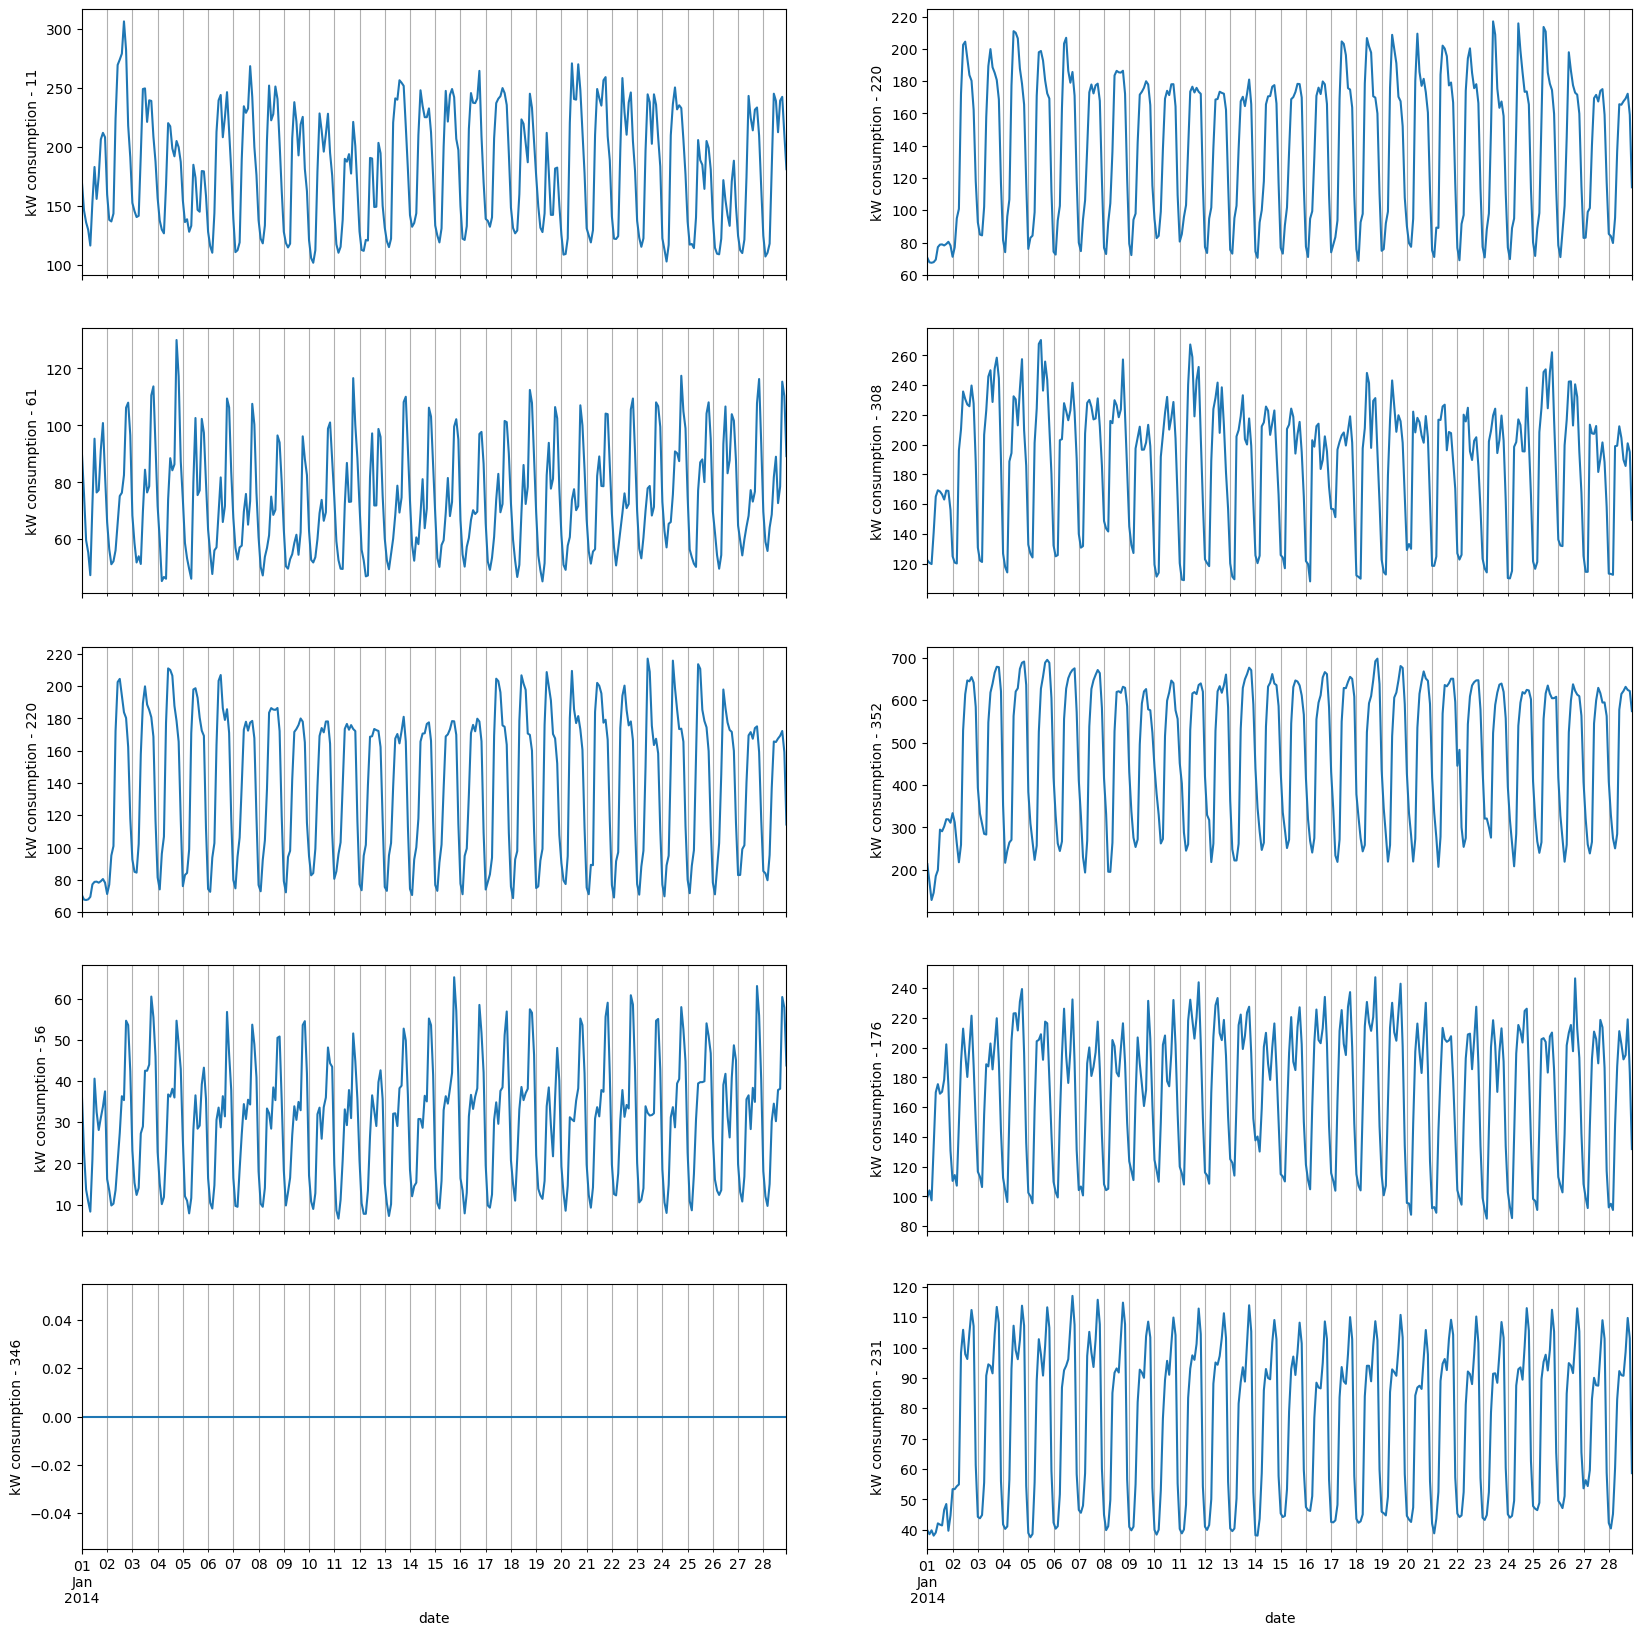

In [15]:
# show random 10 timeseries for 28 day period
fig, axs = plt.subplots(5, 2, figsize=(20, 20), sharex=True)
axx = axs.ravel()
for i, ts_id in enumerate(np.random.randint(1, data_kw.shape[1], size=10).tolist()):
    timeseries[ts_id].loc["2014-01-01":"2014-01-28"].plot(ax=axx[i])
    axx[i].set_xlabel("date")
    axx[i].set_ylabel(f"kW consumption - {ts_id}")
    axx[i].grid(which="minor", axis="x")

Create a smaller dataset with a subset of time series:

In [52]:
# select two random time series to include in a small dataset
sample_size = 2
columns_to_keep = np.random.choice(data_kw.columns.to_list(), size=sample_size, replace=False)
columns_to_keep

array(['MT_338', 'MT_037'], dtype='<U6')

In [53]:
data_kw_small = data_kw[columns_to_keep]
data_kw_small

,MT_338,MT_037
2011-01-01 00:00:00,0.000000,0.000000
2011-01-01 02:00:00,0.000000,0.000000
2011-01-01 04:00:00,0.000000,0.000000
2011-01-01 06:00:00,0.000000,0.000000
2011-01-01 08:00:00,0.000000,0.000000
...,...,...
2014-12-31 16:00:00,378.787879,156.914894
2014-12-31 18:00:00,420.454545,230.415861
2014-12-31 20:00:00,408.008658,179.158607
2014-12-31 22:00:00,241.883117,163.442940


In [18]:
# timeseries_small = []
# for i in tqdm.trange(data_kw_small.shape[1]):
#     timeseries_small.append(np.trim_zeros(data_kw_small.iloc[:, i], trim="f"))

## Deploy Chronos models
This notebook uses the [`JumpStartModel`](https://docs.aws.amazon.com/sagemaker/latest/dg/jumpstart-foundation-models-use-python-sdk.html) class in the SageMaker Python SDK. SageMaker JumpStart models can be deployed using the model ID. 

You can also deploy a Chronos model directly from the Studio UI. For example, open the link constructed by the following code cell to see a Chronos model in the SageMaker JumpStart.

This notebook uses SageMaker Python SDK to deploy three Chronos models as SageMaker real-time inference endpoints.

In [19]:
# Show the JumpStart model link
model_to_show = 'chronos-t5-small'
display(
    HTML('<b>See <a target="top" href="https://studio-{}.studio.{}.sagemaker.aws/jumpstart/SageMakerPublicHub/Model/autogluon-forecasting-{}">JumpStart Chronos model</a> in the Studio UI</b>'.format(
            domain_id, region, model_to_show))
)

You need an GPU-instance for an endpoint to run Chronos `large`, `base`, and `small` models. You can run `mini` and `tiny` models on a CPU-based instance.

### Check quotas for endpoint instances
Before deploying models, you need to check if you have an account-level quota for the specific GPU-instances like `ml.g5.*`.

In [20]:
def check_quota(models):
    quotas_client = boto3.client("service-quotas")

    for m in models:
        r = quotas_client.get_service_quota(
            ServiceCode="sagemaker",
            QuotaCode=m["quota_code"],
        )
    
        q = r["Quota"]["Value"]
        n = r["Quota"]["QuotaName"]
        min_n = m["min_number"] if m.get("min_number") else 1

        print(f"WARNING: Quota {q} for {n} < required {min_n}" if q < min_n else f"SUCCESS: Quota {q} for {n} >= required {min_n}")
        

The following dictionary defines which models this notebooks is going to deploy and what ML instances is used. If you don't have sufficient quota for the corresponding ML instance, set the value of `deploy` key to `False`. As a minimal setup, you can deploy only the `chronos-t5-small` model to experiment with the inference.

In [21]:
model_map = [
    {"model":"chronos-t5-small",
     "instance":"ml.g5.xlarge",
     "quota_code":"L-1928E07B",
     "deploy": True,
    },
    {"model":"chronos-t5-base",
     "instance":"ml.g5.2xlarge",
     "quota_code":"L-9614C779",
     "deploy": True,
    },
    {"model":"chronos-t5-large",
     "instance":"ml.g5.4xlarge",
     "quota_code":"L-C1B9A48D",
     "deploy": True,
    },
]

In [22]:
# check if you have account-level quota for the required inference instance
check_quota(model_map)

SUCCESS: Quota 4.0 for ml.g5.xlarge for endpoint usage >= required 1
SUCCESS: Quota 2.0 for ml.g5.2xlarge for endpoint usage >= required 1
SUCCESS: Quota 2.0 for ml.g5.4xlarge for endpoint usage >= required 1


<div class="alert alert-info">
If you using an AWS-provisioned workshop account, you cannot change quotas. If you don't have sufficient quotas for <code>ml.g5.*</code>, try <code>ml.g4dn.2xlarge </code> or <code>ml.g4dn.4xlarge </code> instances.
</div>

### Custom predictor class
Implement a wrapper for the Chronos predictor to conveniently pass Pandas series to the predictor and convert the response also to Pandas series.

Chronos model interface receives the following JSON as the input. You specify target time series and inference parameters like prediction length and quantiles to generate:

```
{
    "inputs": [
        {"target": [0.0, 4.0, 5.0, 1.5, -3.0, -5.0, -3.0, 1.5, 5.0, 4.0, 0.0, -4.0, -5.0, -1.5, 3.0, 5.0, 3.0, -1.5, -5.0, -4.0]}
    ],
    "parameters": {
        "prediction_length": 10,
        "quantile_levels": [0.1, 0.5, 0.9]
    }
}
```

The model output is a JSON document which contains the predicted time series per quantile and the mean prediction:
```
{
    "predictions": [
        {
            "mean": [-0.0, 3.5, 4.2, 1.7, -1.5, -3.5, -1.9, 1.3, 3.8, 3.4],
            "0.1": [-2.4, 1.5, 2.2, 0.0, -4.9, -5.0, -4.9, -1.5, 1.4, 0.9],
            "0.5": [-0.0, 3.0, 4.0, 1.5, -1.5, -4.9, -2.8, 1.5, 4.5, 3.0],
            "0.9": [1.7, 5.6, 5.5, 3.1, 0.4, 0.0, 3.0, 3.2, 5.0, 5.0]
        }
    ]
}
```

The following code implements a custome predictor class derived from the SageMaker Python SDK [`Predictor`](https://sagemaker.readthedocs.io/en/stable/api/inference/predictors.html#sagemaker.predictor.Predictor).

In [23]:
from sagemaker.serializers import IdentitySerializer

class ChronosPredictor(sagemaker.predictor.Predictor):
    def __init__(self, *args, **kwargs):
        super().__init__(
            *args,
            # serializer=JSONSerializer(),
            serializer=IdentitySerializer(content_type="application/json"),
            **kwargs,
        )

    def predict(
        self,
        ts_list,
        prediction_length=64,
        quantiles=[0.10, 0.5, 0.90],
    ):
        """Requests the prediction of for the time series listed in `ts`
        ts_list -- list of `pandas.Series` objects, the time series to predict
        prediction_length -- number of data points to predict, dimension is the sampling interval
        quantiles -- list of strings specifying the quantiles to compute (default: ["0.1", "0.5", "0.9"])
    
        Return value: list of `pandas.DataFrame` objects containing the predictions
        """
        prediction_start = ts_list[0].index[-1] + ts_list[0].index.freq
        req = self.__encode_request(ts_list, prediction_length, quantiles)
            
        res = super(ChronosPredictor, self).predict(req)
        
        return self.__decode_response(res, ts_list[0].index.freq, prediction_start)

    def __encode_request(self, ts_list, prediction_length, quantiles):
        parameters = {
            "parameters": {
                "prediction_length": prediction_length,
                "quantile_levels": quantiles,
            }
        }
    
        inputs = {"inputs":[series_to_dict(ts) for ts in ts_list]}
    
        http_request_data = {**inputs, **parameters}
    
        return json.dumps(http_request_data).encode("utf-8")

    def __decode_response(self, response, freq, prediction_start):
        # Chronos supports multiple time series in the inference request
        predictions = json.loads(response.decode("utf-8"))["predictions"]
        prediction_index = pd.date_range(
            start=prediction_start, freq=freq, periods=len(predictions[0]["mean"])
        )
    
        return [pd.DataFrame(
            data=p, index=prediction_index
            ) for p in predictions]

def encode_target(ts):
    return [x if np.isfinite(x) else "NaN" for x in ts]

def series_to_dict(ts):
    return {"target": encode_target(ts), "item_id": ts.name}

### Deploy endpoints
Now use `JumpStartModel` and the custome `ChronosPredictor` to create and deploy Chronos models. For the full list of available model ids for JumpStart refer to [Built-in Algorithms with pre-trained Model Table
](https://sagemaker.readthedocs.io/en/stable/doc_utils/pretrainedmodels.html) in SageMaker Python SDK documentation.

In [24]:
chronos_predictors = {}

for m in model_map:
    if m['deploy']:
        model = JumpStartModel(
            model_id="autogluon-forecasting-" + m["model"],
            model_version="1.0.0",
            predictor_cls=ChronosPredictor,
        )
    
        print(f"Start deploying {m['model']} on {m['instance']}")
        chronos_predictors[m["model"]] =  model.deploy(
            instance_type=m["instance"],  # single-GPU g5, p3, g4dn instances supported
            wait=False,
        )

Start deploying chronos-t5-small on ml.g5.xlarge
Start deploying chronos-t5-base on ml.g5.2xlarge
Start deploying chronos-t5-large on ml.g5.4xlarge


Wait until all endpoints are in service. The deployment takes about 5-7 minutes.

In [32]:
%%time

# Wait until all endpoints have the status InService
for p in chronos_predictors.values():
    waiter = sagemaker_session.sagemaker_client.get_waiter('endpoint_in_service')
    waiter.wait(EndpointName=p.endpoint_name)

CPU times: user 16.3 ms, sys: 11.1 ms, total: 27.5 ms
Wall time: 150 ms


## Using Chronos real-time endpoints

### Generate predictions
Run a sample prediction to test an endpoint.

In [ ]:
assert(len(chronos_predictors.values()) > 0)

In [25]:
# predict for 7 days
prediction_days = 7
intervals_per_day = 12
prediction_length = prediction_days * intervals_per_day
context_length = prediction_length * 10
forecast_quantiles = [0.10, 0.5, 0.90]

In [26]:
# get the first time series as a sample for a prediction
ts = timeseries[0][len(timeseries[0])-context_length:]

In [27]:
ts

2014-10-23 02:00:00    1.903553
2014-10-23 04:00:00    2.220812
2014-10-23 06:00:00    1.903553
2014-10-23 08:00:00    1.903553
2014-10-23 10:00:00    2.855330
                         ...   
2014-12-31 16:00:00    2.379442
2014-12-31 18:00:00    2.220812
2014-12-31 20:00:00    2.379442
2014-12-31 22:00:00    2.062183
2015-01-01 00:00:00    0.317259
Freq: 2H, Name: MT_001, Length: 840, dtype: float64

Chronos generates a forecast for `prediction_length` data points starting from the end of the provided time series:

In [28]:
list(chronos_predictors.values())[0].predict(
    [ts],
    prediction_length,
    forecast_quantiles
)[0]

,mean,0.1,0.5,0.9,item_id
2015-01-01 02:00:00,0.907407,0.324074,0.478395,1.944445,MT_001
2015-01-01 04:00:00,1.250000,0.154321,1.072531,2.424383,MT_001
2015-01-01 06:00:00,1.626543,0.154321,1.666667,3.041667,MT_001
2015-01-01 08:00:00,1.087191,0.154321,1.026235,2.222222,MT_001
2015-01-01 10:00:00,0.854938,0.138889,0.478395,1.791667,MT_001
...,...,...,...,...,...
2015-01-07 16:00:00,2.268510,1.235010,2.221186,3.833263,MT_001
2015-01-07 18:00:00,2.229582,1.097617,2.381478,3.575270,MT_001
2015-01-07 20:00:00,2.295225,1.251802,2.373845,3.269952,MT_001
2015-01-07 22:00:00,2.313545,1.114409,2.381478,3.282165,MT_001


### Vizualize predictions
Define a plotting function that sends an input time series to the endpoint and then plots the generated result. 
Note, that all `*_length` parameters are in the **units of aggregation interval**. For example, for `2H` aggregation, if you'd like to generate a forecast for one day, you need 24/2=12 data points. To predict 7 days in 2H intervals, set the `prediction_length` to 7*12=84.

In [29]:
start_dataset = pd.Timestamp("2011-01-01 00:00:00", unit=freq)
end_dataset = pd.Timestamp("2014-12-31 00:00:00", unit=freq)

In [30]:
# plot an individual time series
def plot_series(
    input_ts,
    prediction_ts,
    low_quantile,
    up_quantile,
    ax,
):
    ax.set_title(f"{input_ts.name}")
    input_ts.plot(ax=ax, color="black", label="target")

    # plot the confidence interval p90-p10, p50, and the mean predicted
    ax.fill_between(
        prediction_ts[low_quantile].index,
        prediction_ts[low_quantile].values,
        prediction_ts[up_quantile].values,
        color="b",
        alpha=0.3,
        label="{}% confidence interval".format(80),
    )
    prediction_ts['mean'].plot(ax=ax, color="r", label="mean")
    prediction_ts['0.5'].plot(ax=ax, color="b", label="P50")
    ax.legend(loc='upper left')

    # fix the scale as the samples may change it
    ax.set_ylim(input_ts.min() * 0.5, input_ts.max() * 1.5)

# plot all input time series and all predictions
def plot(
    predictor,
    ts_list,
    context_end=end_dataset,
    context_length=512,
    prediction_length=prediction_length,
    show_history_length=prediction_length*3,
    display_data=False,
):
    freq = ts_list[0].index.freq

    # construct a list of pandas.Series to send to the predictor
    inference_ts = [ts[context_end - context_length*freq : context_end] for ts in ts_list]

    prediction_start = inference_ts[0].index[-1] + inference_ts[0].index.freq
    print(f"calling the endpoint to generate predictions starting from {str(prediction_start)}")

    if display_data:
        print(f"""
        Input data:
        {inference_ts}
        """)

    # call the end point to get the prediction
    predictions = predictor.predict(
        ts_list=inference_ts,
        prediction_length=prediction_length,
        quantiles=forecast_quantiles
    )

    if display_data:
        print(f"""
        Model output:
        {predictions}
        """)

    n_ts = len(predictions)
    fig, axs = plt.subplots(n_ts, 1, figsize=(20, 7*n_ts))
    axx = [axs] if n_ts == 1 else axs.ravel()

    for i, prediction in enumerate(predictions):
        plot_series(
            ts_list[i][context_end - show_history_length*freq : context_end + prediction_length * freq],
            prediction,
            '0.1',
            '0.9',
            axx[i],
        )

    plt.tight_layout()
    plt.show()

Experiment with different Chronos model sizes, time series, context lengths, and prediction lengths to generate predictions. You can change the following parameters:

- `Model`: size of the Chronos model. The input is sent to the corresponding deployed model
- `Time series ids`: ids of the time series in the full dataset. You can select multiple time series to predict and to plot  
- `Predict from`: start of the prediction interval  
- `Context length`: how many data points are sent to the model  
- `Prediction length`: lenght of the predicted time series in frequency units
- `History lenght`: how many 'prediction lengths' of history are shown on the plot as the history time series
- `Show datasets`: turn on this option if you would like to see the input and output datasets  

In [31]:
style = {"description_width": "initial"}
ts_id_list = [ts.name for ts in timeseries]

In [32]:
@interact_manual(
    predictor=Dropdown(options=list(chronos_predictors.keys()), description='Model:'),
    ts_ids=SelectMultiple(options=ts_id_list, value=[ts_id_list[0]], rows=5, style=style, description='Time series ids:'),
    context_end=DatePicker(value=end_dataset, style=style, description='Predict from:'),
    context_length=IntSlider(min=prediction_length, max=4096, value=prediction_length*4, style=style, description='Context length:'),
    prediction_length=IntSlider(min=1, max=prediction_length*4, value=prediction_length, style=style, description='Prediction length:'),
    history_length=IntSlider(min=1, max=10, value=3, style=style, description='History length:'),
    display_data = Checkbox(value=False, style=style, description='Display datasets:'),
    continuous_update=False,
)
def plot_interact(predictor, ts_ids, context_end, context_length, prediction_length, history_length, display_data):
    plot(
        predictor=chronos_predictors[predictor],
        ts_list=[ts for ts in timeseries if ts.name in ts_ids],
        context_end=context_end,
        context_length=context_length,
        prediction_length=prediction_length,
        show_history_length=history_length*prediction_length,
        display_data=display_data,
    )

interactive(children=(Dropdown(description='Model:', options=('chronos-t5-small', 'chronos-t5-base', 'chronos-…

## Chronos model performance

In this section you evaluate performance of Chronos models using the deployed real-time inference endpoints and backtesting.

To minimize writing of boilerplate code for time series processing and evaluation, this notebook uses [AutoGluon](https://auto.gluon.ai/) library, more specifically `TimeSeriesDataFrame` and `TimeSeriesPredictor` classes. 

First, you need to install `autogluon` package.

In [33]:
!rm -rf /opt/conda/lib/python3.10/site-packages/fsspec*
%pip install -q fsspec

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 2.19.2 requires fsspec[http]<=2024.3.1,>=2023.1.0, but you have fsspec 2024.9.0 which is incompatible.
jupyter-scheduler 2.7.1 requires fsspec==2023.6.0, but you have fsspec 2024.9.0 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [34]:
%pip install -Uq autogluon

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyter-scheduler 2.7.1 requires fsspec==2023.6.0, but you have fsspec 2024.3.1 which is incompatible.
s3fs 2024.9.0 requires fsspec==2024.9.0.*, but you have fsspec 2024.3.1 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


Import required packages and classes:

In [35]:
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor
from autogluon.timeseries.splitter import ExpandingWindowSplitter
from autogluon.timeseries.metrics.quantile import WQL
from autogluon.timeseries.metrics import (WAPE, MAPE, MASE, RMSE)

from importlib.metadata import version
print(version('autogluon'))

1.1.1


Create helper functions you need to convert between `Pandas.Series` and `TimeSeriesDataFrame`.

In [36]:
# converts a Pandas.DataFrame to AutoGluon TimeSeriesDataFrame
# note the function hardcodes column names and work only with the dataset in this notebook
def get_ts_df(
    df,
) ->  TimeSeriesDataFrame: 
    # Convert to an AutoGluon TimeSeriesDataFrame
    return TimeSeriesDataFrame.from_data_frame(
        # Melt the DataFrame into the long format
        pd.melt(
            df.reset_index(),
            id_vars='index', 
            value_vars=df.columns, 
            var_name='item_id', 
            value_name='target'
        ).rename(columns={'index': 'timestamp'}), # Rename the 'index' column to 'timestamp'
        id_column="item_id",
        timestamp_column="timestamp",
    )

In [37]:
# converts AutoGluon TimeSeriesDataFrame to Pandas.Series
def get_item_series(
    ts_df: TimeSeriesDataFrame,
    target: str = 'target',
):
    series = []

    for item_id in ts_df.item_ids:
        # Get the time series for this item
        item_series = ts_df.loc[item_id]
        
        # Convert to a Pandas Series
        series.append(
            pd.Series(
                item_series[target].values,
                index=pd.DatetimeIndex(item_series.index, freq=ts_df.freq),
                name=item_id,
            )
        )

    return series

In [266]:
# wrapper for Chronos predictor to use TimeSeriesDataFrame as input and output
def predict_ag(
    data: TimeSeriesDataFrame,
    model: str = None,
    prediction_length: int = 64,
    quantiles = [0.10, 0.5, 0.90],
    display_details = True,
) -> TimeSeriesDataFrame:

    model = model if model else list(chronos_predictors.keys())[0]
    predictor = chronos_predictors[model]
    if display_details:
        print(f"Using Chronos model: {model}, number of time series: {data.num_items} , context length: {data.num_timesteps_per_item()[data.item_ids[0]]}, prediction length: {prediction_length}")

    return TimeSeriesDataFrame.from_data_frame(
        pd.concat(
            # call Chronos predictor
            predictor.predict(
                ts_list=get_item_series(data),
                prediction_length=prediction_length,
                quantiles=quantiles,
            )
        ).reset_index().rename(columns={'index':'timestamp'}),
        id_column="item_id",
        timestamp_column="timestamp",
    )

### Convert data to AutoGluon format
First you need to convert time series to `TimeSeriesDataFrame`. The next notebok `lab5_autogluon` has more details on the `TimeSeriesDataFrame`. Refer also to [TimeSeriesDataFrame](https://auto.gluon.ai/stable/api/autogluon.timeseries.TimeSeriesDataFrame.html) documenationt for specific details.

`TimeSeriesDataFrame` inherits from [pandas.DataFrame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html), so all attributes and methods of `pandas.DataFrame` are available in a `TimeSeriesDataFrame`. It also provides useful utility functions, such as loaders for different data formats, slicing by time or time step, and train-test split.

The following code uses a subset with two random time series of the full dataset.

In [54]:
ts_sample_df = get_ts_df(data_kw_small)
ts_sample_df

target
item_id timestamp                      
MT_338  2011-01-01 00:00:00    0.000000
        2011-01-01 02:00:00    0.000000
        2011-01-01 04:00:00    0.000000
        2011-01-01 06:00:00    0.000000
        2011-01-01 08:00:00    0.000000
...                                 ...
MT_037  2014-12-31 16:00:00  156.914894
        2014-12-31 18:00:00  230.415861
        2014-12-31 20:00:00  179.158607
        2014-12-31 22:00:00  163.442940
        2015-01-01 00:00:00   19.100580

[35066 rows x 1 columns]

### Predict using `TimeSeriesDataFrame`
Now you use `TimeSeriesDataFrame` to slice time series to create an inference dataset to send to a deployed Chronos endpoint. For example, to get a slice for inference of the size `context_length`, use the [`slice_by_timestep()`](https://auto.gluon.ai/stable/api/autogluon.timeseries.TimeSeriesDataFrame.slice_by_timestep.html) method:

In [55]:
context_length = prediction_length*2

In [56]:
# note '-1' in end_index to remove the last data point in all series because of an outlier
inference_df = ts_sample_df.slice_by_timestep(
    start_index=-context_length-prediction_length,
    end_index=-prediction_length-1
)

In [57]:
inference_df

target
item_id timestamp                      
MT_338  2014-12-11 02:00:00   90.367965
        2014-12-11 04:00:00   90.909091
        2014-12-11 06:00:00  182.359307
        2014-12-11 08:00:00  242.965368
        2014-12-11 10:00:00  309.523810
...                                 ...
MT_037  2014-12-24 14:00:00  142.891683
        2014-12-24 16:00:00  144.342360
        2014-12-24 18:00:00  204.787234
        2014-12-24 20:00:00  165.860735
        2014-12-24 22:00:00  139.990329

[334 rows x 1 columns]

In [58]:
# the total number of rows in the slice
# '-1' because the last endpoint in all series was removed
(context_length-1)*ts_sample_df.num_items

334

Call the Chronos endpoint:

In [59]:
%%time
prediction_df = predict_ag(
    inference_df,
    prediction_length=prediction_length,
)

Using Chronos model: chronos-t5-small, number of time series: 2 , context length: 167, prediction length: 84
CPU times: user 19.5 ms, sys: 5.98 ms, total: 25.4 ms
Wall time: 822 ms


In [60]:
prediction_df

mean         0.1         0.5         0.9
item_id timestamp                                                          
MT_338  2014-12-25 00:00:00  107.238708   99.491433  102.957321  114.578253
        2014-12-25 02:00:00   94.802284   89.501515   90.724770   92.559652
        2014-12-25 04:00:00   99.695312   91.744148   93.782906  112.335613
        2014-12-25 06:00:00  187.565826  179.410782  183.488297  202.041003
        2014-12-25 08:00:00  242.000687  240.369672  242.612305  244.651062
...                                 ...         ...         ...         ...
MT_037  2014-12-31 14:00:00  122.181442  114.757629  122.612488  127.881001
        2014-12-31 16:00:00  131.042114  125.198855  131.233688  138.034848
        2014-12-31 18:00:00  205.088577  200.107411  206.429626  209.015984
        2014-12-31 20:00:00  191.390457  183.822940  191.582016  199.436882
        2014-12-31 22:00:00  168.304779  164.568947  167.634262  171.465912

[168 rows x 4 columns]

### Visualize predictions using `TimeSeriesPredictor`

To visualize data in `TimeSeriesDataFrame` with minimal coding you can also use AutoGluon, specifically the [`TimeSeriesPredictor`](https://auto.gluon.ai/stable/api/autogluon.timeseries.TimeSeriesPredictor.html) class. The next notebook `lab5_autogluon` explains in more details how to use Chronos in AutoGluon. 

Create a `TimeSeriesPredictor` object. Note that that `fit` doesn't take any time to complete, because `TimeSeriesPredictor` doesn't actually train any Chronos models as they are used for zero-shot predictions. You just use the AutoGluon predictor object an a convenient wrapper around required functionality like plotting.

In [61]:
chronos_predictor_ag = TimeSeriesPredictor(
    prediction_length=prediction_length,
    ).fit(
        train_data=ts_sample_df,
        presets=f"chronos_mini",
        verbosity=0,
    )

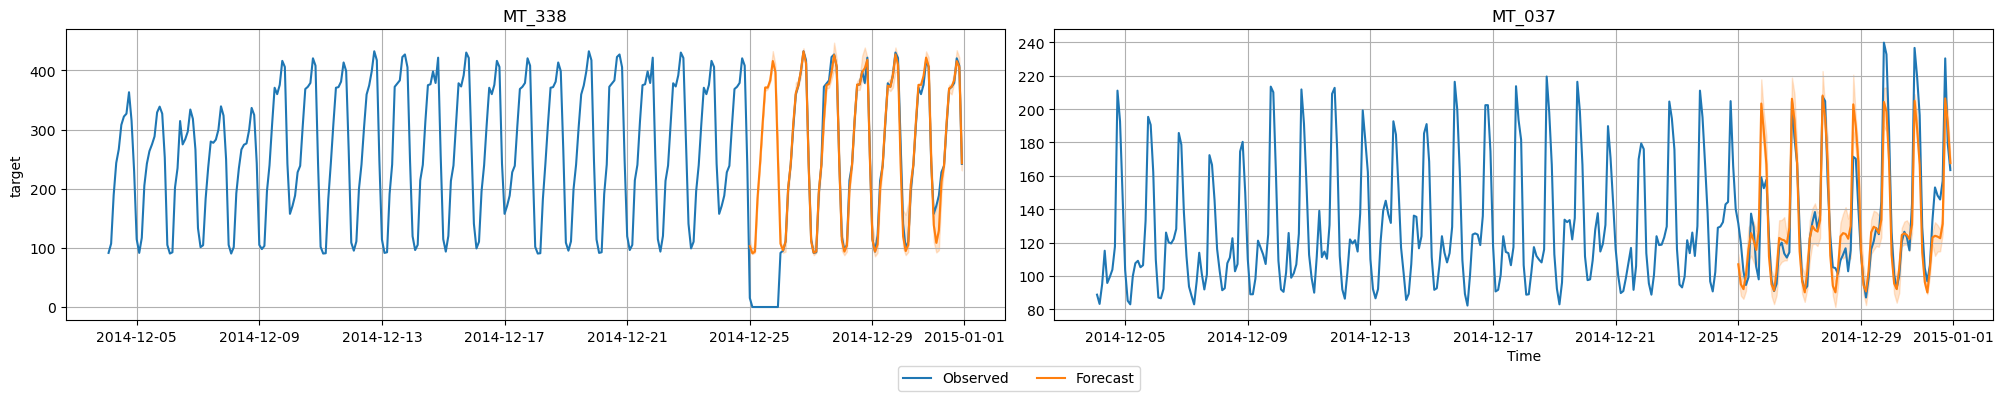

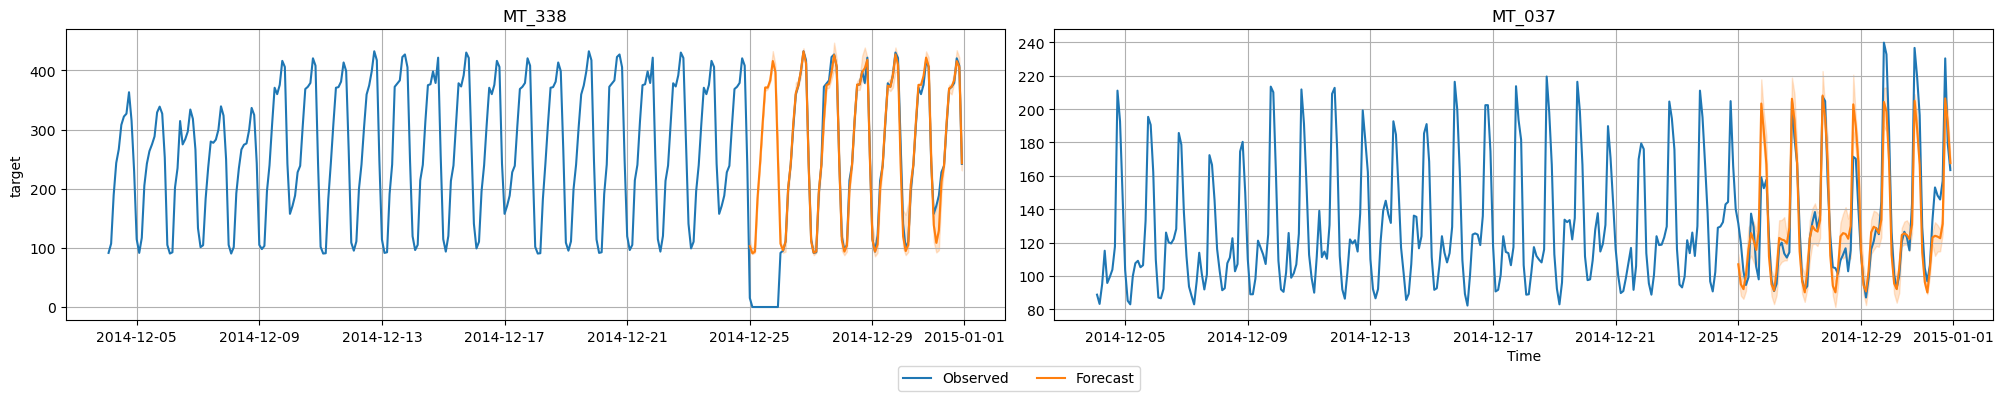

In [62]:
chronos_predictor_ag.plot(
    data=ts_sample_df.slice_by_timestep(start_index=-4*prediction_length, end_index=-1),
    predictions=prediction_df,
    item_ids=ts_sample_df.item_ids[0:2],
)

### Calculate metrics

This notebook uses AutoGluon time series [metrics](https://auto.gluon.ai/stable/tutorials/timeseries/forecasting-metrics.html) to evaluate the performance of Chronos models.

As in previous notebooks, this notebook calculates the following metrics:
- [Weighted quantile loss (WQL)](https://auto.gluon.ai/stable/tutorials/timeseries/forecasting-metrics.html#autogluon.timeseries.metrics.WQL)
- [Mean absolute percentage error (MAPE)](https://auto.gluon.ai/stable/tutorials/timeseries/forecasting-metrics.html#autogluon.timeseries.metrics.MAPE)
- [Weighted absolute percentage error (WAPE)](https://auto.gluon.ai/stable/tutorials/timeseries/forecasting-metrics.html#autogluon.timeseries.metrics.WAPE)
- [Root mean squared error (RMSE)](https://auto.gluon.ai/stable/tutorials/timeseries/forecasting-metrics.html#autogluon.timeseries.metrics.RMSE)
- [Mean absolute scaled error (MASE)](https://auto.gluon.ai/stable/tutorials/timeseries/forecasting-metrics.html#autogluon.timeseries.metrics.MASE)

Note that AutoGluon flips the sign of a metric by multiplying by `-1`.

In [63]:
# helper to calculate scores on a predicted time series given the target time series and metrics
def get_scores(
    metrics,
    data: TimeSeriesDataFrame,
    predictions: TimeSeriesDataFrame,
    prediction_length: int = prediction_length
)-> dict:
    kwargs = {
        'data': data,
        'predictions': predictions,
        'prediction_length': prediction_length,
    }

    return {m.__class__.__name__:m(**kwargs) for m in metrics}

In [64]:
# define metrics you need to calculate
metrics = [WQL(), MAPE(), WAPE(), RMSE(), MASE()]

In [65]:
# calculate the metrics for the prediction sample from the previous section
get_scores(metrics, ts_sample_df.slice_by_timestep(end_index=-1), prediction_df)

{'WQL': -0.13835839788214468,
 'MAPE': -0.1006929053352225,
 'WAPE': -0.15337463282290204,
 'RMSE': -79.89845871596829,
 'MASE': -2.404024291897436}

In the following sections **Backtest** and **Backtest with multiple windows** you calculate metrics for all deployed Chronos models and for the full dataset.

### How context length impacts model accuracy

Let's see how the context length sent to a Chronos model affects model accuracy. The context lenght defines how many data points the model sees before generating predictions. The following code sends different number of time steps of the target time series to the predictor. 

In [66]:
# helper to predict and calculate scores
def predict_and_score(
    ts_df: TimeSeriesDataFrame,
    inference_df: TimeSeriesDataFrame,
    metrics,
    model: str = None,
    prediction_length=prediction_length,
    offset=1,
    display_details=False,
):
    return get_scores(
        metrics, 
        ts_df.slice_by_timestep(end_index=-(offset-1)*prediction_length if offset > 1 else None),
        predict_ag(
            inference_df, 
            model,
            prediction_length=prediction_length,
            display_details=display_details,
        )
    )

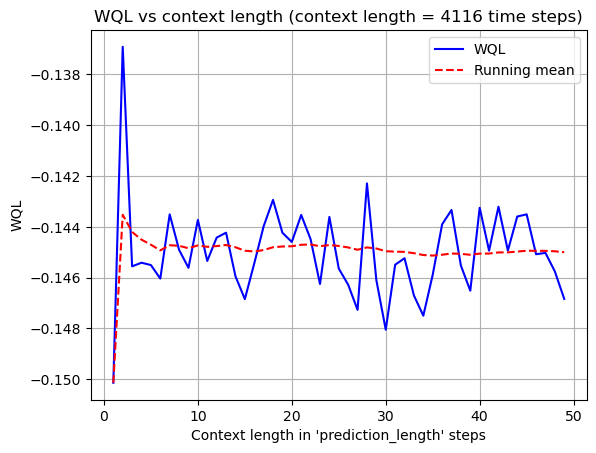

In [67]:
# Set up the plot
plt.figure(figsize=(10, 6))
plt.title("WQL vs context length")
plt.xlabel("Context length in 'prediction_length' steps")
plt.ylabel("WQL")
    
x_data = []
y_data = []
mean_data = []
n_context_length_steps = 50

for i in range(1, n_context_length_steps):
    # Calculate and store scores
    x_data.append(i)
    y_data.append(predict_and_score(
            ts_sample_df.slice_by_timestep(end_index=-1),
            ts_sample_df.slice_by_timestep(
                    start_index=-prediction_length*(i+1),
                    end_index=-prediction_length-1
                ),
            [WQL()],
        )['WQL']
    )
    mean_data.append(np.mean(y_data))
        
    # Clear the previous plot
    clear_output(wait=True)
        
    # Create new plot
    plt.clf()
    plt.plot(x_data, y_data, 'b-', label='WQL')
    plt.plot(x_data, mean_data, 'r--', label='Running mean')
    plt.title(f"WQL vs context length (context length = {i*prediction_length} time steps)")
    plt.xlabel("Context length in 'prediction_length' steps")
    plt.ylabel("WQL")
    plt.legend()
    plt.grid(True)
    
    # Display the plot
    plt.pause(0.1)  # Pause to allow the plot to update
    
plt.show()  # Show the final plot

As you can see, prediction accuracy isn't significantly affected by the context length provided you supply the model with at least `prediction length`-number of data points. For this specific sample of time series, the best context length is around one or two times the `prediction length`. If you send more data points to the model it can be "distracted" by more data and prediction accuracy decreases. For other datasets with more pronounced seasonal trends or long sequences results can be different.

As Chronos models are pretrained models and can work with any context and prediction lengths, you can experiment with `prediction_length` on your own and see how it impacts on prediction accuracy.

### Backtest

Having all required tools you can now implement a backtest of Chronos model predictions. In this section you calculate performance metrics for all deployed Chronos models and all time series in the dataset.

In [68]:
# use the full dataset
test_data = data_kw
test_data

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
2011-01-01 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-01-01 02:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-01-01 04:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-01-01 06:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-01-01 08:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-12-31 16:00:00,2.379442,28.538407,1.954822,160.569106,67.225610,260.416667,7.560769,352.693603,75.830420,53.897849,...,439.864383,40675.0,2816.983122,3980.113636,127.933507,7.753072,504.938543,118.948247,703.445748,12033.783784
2014-12-31 18:00:00,2.220812,28.449502,2.172024,208.587398,91.310976,385.788690,12.719050,359.427609,95.498252,84.408602,...,425.053533,43300.0,2793.776371,3454.545455,105.606258,5.266238,500.877963,47.787980,706.011730,9554.054054
2014-12-31 20:00:00,2.379442,24.004267,1.737619,174.288618,89.176829,330.357143,11.447145,292.508418,84.134615,75.806452,...,330.389008,39137.5,1676.160338,1857.954545,74.967405,4.169105,420.654083,131.886477,675.219941,8344.594595
2014-12-31 22:00:00,2.062183,21.692745,1.737619,161.331301,85.365854,311.383929,11.023177,251.262626,68.181818,72.446237,...,289.079229,31775.0,1591.244726,1303.977273,46.284224,7.533645,665.605795,178.422371,669.263196,7263.513514


Before calculating metrics for all deployed Chronos models and the full datasat, let's construct a sample code step by step and see what happens at each step.
Note the usage of an `offset` variable. This allows you to select a period to predict for the backtest from the middle of the dataset rather than the last period of the time series. Using `offset` you can avoid including anomalies like December 25th with very low electricity consumption into your backtesting period. Selection of a backtesting period should be made specifically for each use case and time series. You can experiment with different `offset` settings and compare metrics.

In [69]:
# Set basic variables
context_length = prediction_length*2 # how many data points are sent to the model
batch_size = 50 # how many time series are sent to the model in one request
sample_size = 4 # how many time series are randomly selected for the sample calculation
offset = 10 # prediction offset counted from the end of the time series in 'prediction_length' units. Set to 1 to predict the last 'prediction_length' of the time series

metrics = [WQL(), MAPE(), WAPE(), RMSE(), MASE()]

In [70]:
# randomly select 'sample_size' number of time series from the full dataset
inference_items = np.random.choice(test_data.columns.to_list(), size=sample_size, replace=False)

Calculate metrics for a sample of the time series: ['MT_060' 'MT_246' 'MT_010' 'MT_301']
Context length: 168 Prediction lenght: 84 Offset: 10
Using Chronos model: chronos-t5-small, number of time series: 4 , context length: 168, prediction length: 84


{'WQL': -0.04724375547563286,
 'MAPE': -0.14357619812712943,
 'WAPE': -0.06726566442619725,
 'RMSE': -23.141599834960232,
 'MASE': -1.3094502350767385}

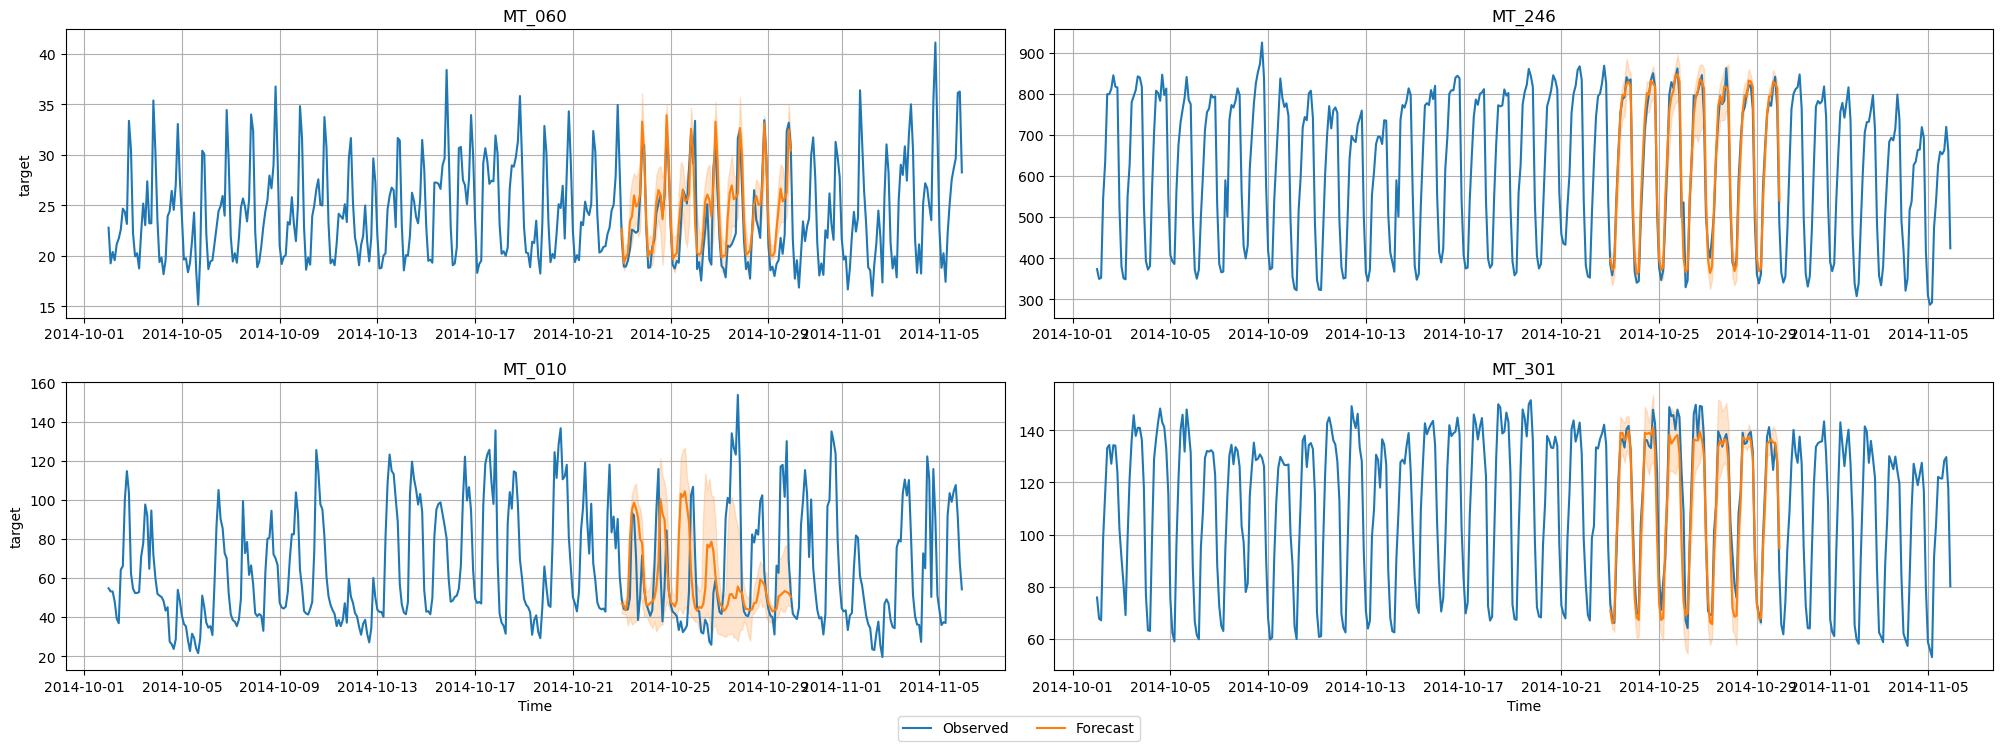

In [71]:
print(f"Calculate metrics for a sample of the time series: {inference_items}")
print(f"Context length: {context_length} Prediction lenght: {prediction_length} Offset: {offset}")

# Step 1: Get the target time series
# get the full length of the time series into a TimeSeriesDataFrame object
# drop the last data point because it's an outlier and afffects the score
data = get_ts_df(test_data[inference_items]).slice_by_timestep(end_index=-1)
# print(data)

# Step 2: Get the inference dataset
# get the inference dataset as a slice of the length = context_length counted back from the offset point
inference_df = data.slice_by_timestep(
                start_index=-context_length-prediction_length*offset,
                end_index=-prediction_length*offset,
            )
# print(inference_df)

# Step 3: Predict
# call a Chronos endpoint to generate predictions
# Chronos models generate prediction starting from the last provided data point
prediction_df = predict_ag(
            inference_df, 
            prediction_length=prediction_length,
        )
# print(prediction_df)

# get a slice of the full dataset with lenght = 5 * prediction_length
# this slice is used to visualize the target time series
target_df = data.slice_by_timestep(
            start_index=-(offset+3)*prediction_length, 
            end_index=-(offset-2)*prediction_length if offset > 2 else None,
        )
# print(target_df)

# use TimeSeriesPredictor to visualize the target timeseries and predictions
chronos_predictor_ag.plot(
        data=target_df,
        predictions=prediction_df,
        item_ids=inference_items,
    )

# Step 4: Score
# calculate metric scores for the predicted time series
# note you need align the ends of target and prediction datasets
scores = get_scores(
    metrics, 
    data.slice_by_timestep(end_index=-(offset-1)*prediction_length if offset > 1 else None), 
    prediction_df
)

scores

Compile all code above into a single function which sends time series to a Chronos endpoint in batches and returns calculated metrics by the batch:

In [160]:
def run_backtest(
    model: str,
    test_data: pd.DataFrame,
    item_ids: [str],
    metrics,
    prediction_length: int,
    context_length: int,
    batch_size: int,
    offset: int,
    display_items = False,
    
) -> pd.DataFrame:

    print(f"""
    Running inference and scoring for model: {model} 
    Number of time series: {len(item_ids)} sent in batches of {batch_size}
    Context length: {context_length} Prediction lenght: {prediction_length} Offset: {offset}
    """)
    
    scores = []
    
    for i in (pbar := trange(-(len(item_ids)//-batch_size))):
        inference_items = item_ids[i*batch_size:(i+1)*batch_size]
        if display_items: pbar.write(f"Inferencing the items: {inference_items}")
    
        data = get_ts_df(test_data[inference_items]).slice_by_timestep(end_index=-1)
        scores.append(predict_and_score(
                data,
                data.slice_by_timestep(
                    start_index=-context_length-prediction_length*offset,
                    end_index=-prediction_length*offset,
                ),
                metrics,
                model=model,
                offset=offset,
            )
        )

    return pd.DataFrame(data=scores)

In [161]:
# prepare agruments for the function call
kwargs = {
    'test_data': test_data,
    'item_ids': test_data.columns.to_list(),
    'metrics': metrics,
    'prediction_length': prediction_length,
    'context_length': context_length,
    'batch_size': batch_size,
    'offset': offset,
}

<div class="alert alert-info">The backtest run with three deployed Chronos models and the full dataset takes about 5 minutes.</div>

In [162]:
# run backtest for all deployed models
backtest_scores = [{'model':m, 'score':run_backtest(model=m, **kwargs)} for m in chronos_predictors.keys()]


    Running inference and scoring for model: chronos-t5-small 
    Number of time series: 370 sent in batches of 50
    Context length: 168 Prediction lenght: 84 Offset: 10
    


  0%|          | 0/8 [00:00<?, ?it/s]


    Running inference and scoring for model: chronos-t5-base 
    Number of time series: 370 sent in batches of 50
    Context length: 168 Prediction lenght: 84 Offset: 10
    


  0%|          | 0/8 [00:00<?, ?it/s]


    Running inference and scoring for model: chronos-t5-large 
    Number of time series: 370 sent in batches of 50
    Context length: 168 Prediction lenght: 84 Offset: 10
    


  0%|          | 0/8 [00:00<?, ?it/s]

In [163]:
# display scores for each model
# using mean() here to aggregate metrics over all time series
[print(f"Model: {s['model']}\n{s['score'].mean()}") for s in backtest_scores]

Model: chronos-t5-small
WQL      -0.062748
MAPE     -0.622169
WAPE     -0.088835
RMSE   -332.786067
MASE     -1.643680
dtype: float64
Model: chronos-t5-base
WQL      -0.056599
MAPE     -0.500140
WAPE     -0.082525
RMSE   -269.005486
MASE     -1.550388
dtype: float64
Model: chronos-t5-large
WQL      -0.056483
MAPE     -0.449022
WAPE     -0.080413
RMSE   -278.150804
MASE     -1.523841
dtype: float64


[None, None, None]

#### Save the model performance to a file

In [164]:
# helper to create a DataFrame with metrics
def get_metrics_df(
    model_metrics: dict,
    experiment_name: str,
    timestamp=strftime("%Y%m%d-%H%M%S", gmtime()),
) -> pd.DataFrame:
    model_metrics_df = pd.DataFrame.from_dict(model_metrics, orient='index', columns=['value']).reset_index().rename(columns={'index': 'metric_name'})
    model_metrics_df['experiment'] = experiment_name
    model_metrics_df['timestamp'] = timestamp
    # AutoGluon flips the sign of a metric, multiply by -1
    model_metrics_df['value'] = model_metrics_df['value'] * (-1)
    model_metrics_df = model_metrics_df[['timestamp', 'metric_name', 'value', 'experiment']]

    # print(model_metrics_df)
    return model_metrics_df

In [165]:
os.makedirs("./model-performance", exist_ok=True)

In [166]:
# construct a DataFrame with all metrics for all models
model_metrics_df = pd.concat([
    get_metrics_df(
        s['score'].mean().to_dict(),
        f"{experiment_prefix}-{s['model']}-{freq}-{test_data.shape[1]}-{test_data.shape[0]}-off{offset}",
    ) for s in backtest_scores
])

model_metrics_df

,timestamp,metric_name,value,experiment
0,20240917-205300,WQL,0.062748,chronos-chronos-t5-small-2H-370-17533-off10
1,20240917-205300,MAPE,0.622169,chronos-chronos-t5-small-2H-370-17533-off10
2,20240917-205300,WAPE,0.088835,chronos-chronos-t5-small-2H-370-17533-off10
3,20240917-205300,RMSE,332.786067,chronos-chronos-t5-small-2H-370-17533-off10
4,20240917-205300,MASE,1.643680,chronos-chronos-t5-small-2H-370-17533-off10
0,20240917-205300,WQL,0.056599,chronos-chronos-t5-base-2H-370-17533-off10
1,20240917-205300,MAPE,0.500140,chronos-chronos-t5-base-2H-370-17533-off10
2,20240917-205300,WAPE,0.082525,chronos-chronos-t5-base-2H-370-17533-off10
3,20240917-205300,RMSE,269.005486,chronos-chronos-t5-base-2H-370-17533-off10
4,20240917-205300,MASE,1.550388,chronos-chronos-t5-base-2H-370-17533-off10


In [167]:
# save the metrics df to the file
experiment_name = f"{experiment_prefix}-{freq}-{test_data.shape[1]}-{test_data.shape[0]}-off{offset}"
model_metrics_df.to_csv(
    f"./model-performance/{experiment_name}-{model_metrics_df['timestamp'].iloc[0]}.csv",
    index=False
)

### Optional: backtest with multiple windows

Instead of evaluating only one prediction period for each time series in the dataset, you can score a model using multiple rolling windows from the same time series. In the backtest with multiple windows you repeatedly testing a model on different subsets of historical data, moving forward in time with each iteration. 

This approach allows for a more robust assessment of the model's performance across various time periods, providing insights into its stability and predictive power under different conditions.

The AutoGluon class [`ExpandingWindowSplitter`](https://auto.gluon.ai/stable/tutorials/timeseries/forecasting-indepth.html) provides the needed functionality to split the dataset.

Try different `n_windows` and `sample_sizes` below to see how Chronos predicts individual time series from the dataset.

In [275]:
# Set basic variables
context_length = prediction_length*2 # how many data points are sent to the model
batch_size = 50 # how many time series are sent to the model in one request
n_windows = 4 # number of rolling windows from the end of the time series to evaluate
sample_size = 4 # how many time series are randomly selected for the sample calculation

metrics = [WQL(), MAPE(), WAPE(), RMSE(), MASE()]

As with **Backtest** you first run backtest with rolling windows on a sample dataset and visualize it to understand in details what is happening.

In [276]:
# randomly select 'sample_size' number of time series from the full dataset
inference_items = np.random.choice(test_data.columns.to_list(), size=sample_size, replace=False)

Using Chronos model: chronos-t5-small, number of time series: 4 , context length: 168, prediction length: 84
Window 0 score:
{'WQL': -0.06435609884550926, 'MAPE': -0.13795596152297737, 'WAPE': -0.08253442320654611, 'RMSE': -42.28929901415394, 'MASE': -3.719522166035963}
Using Chronos model: chronos-t5-small, number of time series: 4 , context length: 168, prediction length: 84
Window 1 score:
{'WQL': -0.033650832213090454, 'MAPE': -0.08142025296878937, 'WAPE': -0.05120361958002731, 'RMSE': -23.560973350070697, 'MASE': -1.6011815740435973}
Using Chronos model: chronos-t5-small, number of time series: 4 , context length: 168, prediction length: 84
Window 2 score:
{'WQL': -0.05412637073813977, 'MAPE': -0.08917827858279094, 'WAPE': -0.06879908874842275, 'RMSE': -43.10906998554454, 'MASE': -2.075637786367366}
Using Chronos model: chronos-t5-small, number of time series: 4 , context length: 168, prediction length: 84
Window 3 score:
{'WQL': -0.111537683302674, 'MAPE': -0.1249704781043201, 'W

,WQL,MAPE,WAPE,RMSE,MASE
0,-0.064356,-0.137956,-0.082534,-42.289299,-3.719522
1,-0.033651,-0.081420,-0.051204,-23.560973,-1.601182
2,-0.054126,-0.089178,-0.068799,-43.109070,-2.075638
3,-0.111538,-0.124970,-0.134199,-73.147867,-2.879029


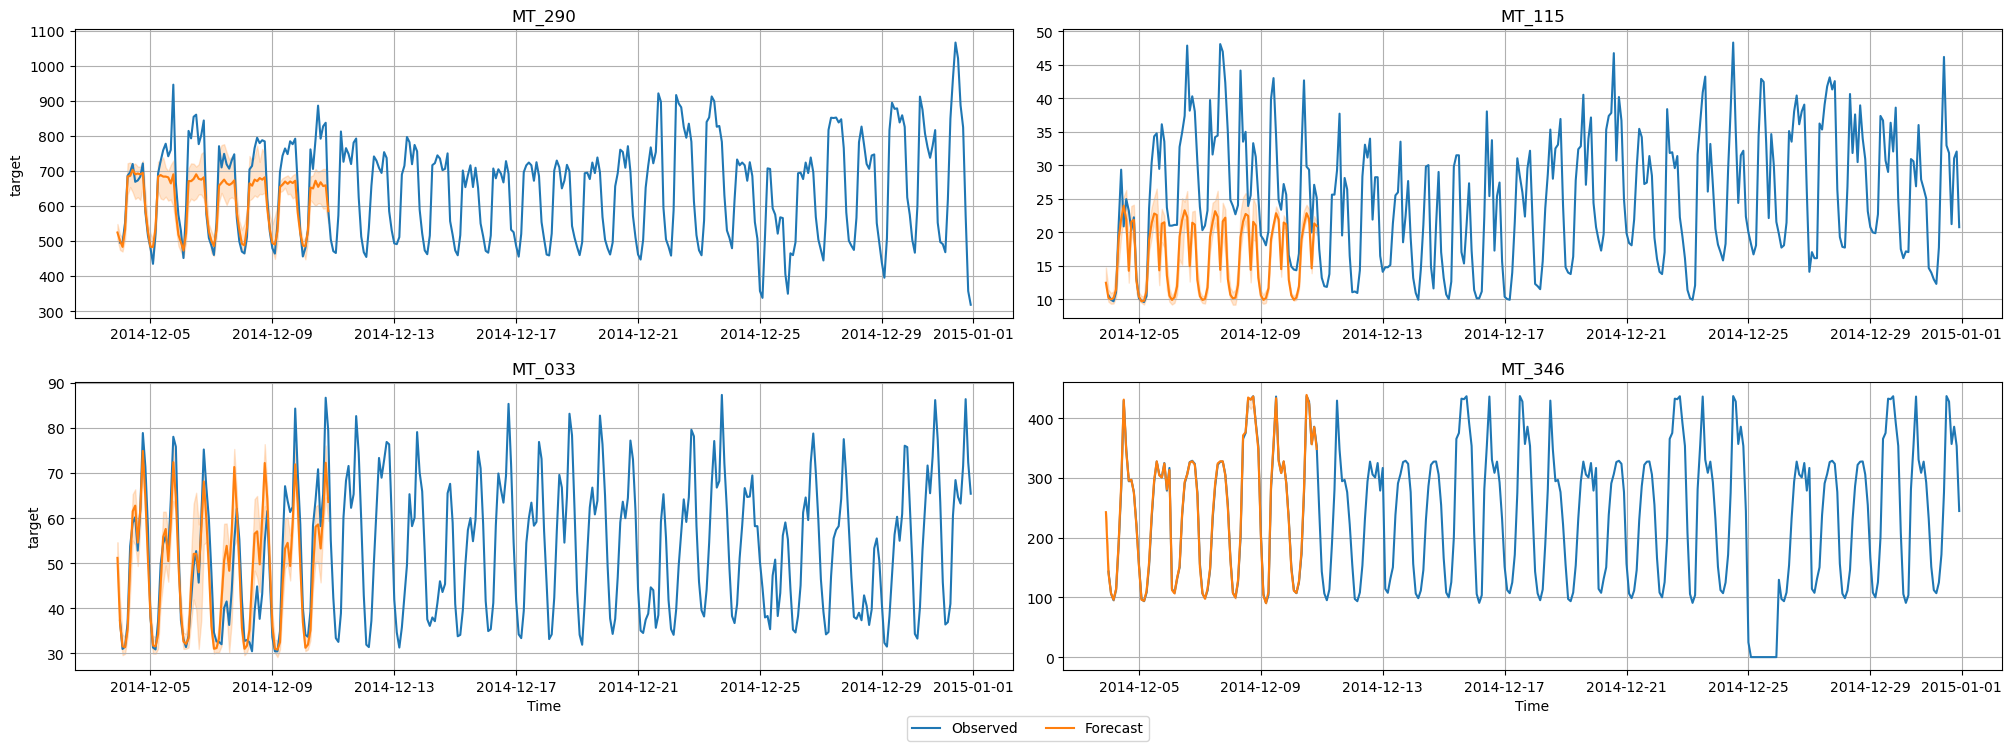

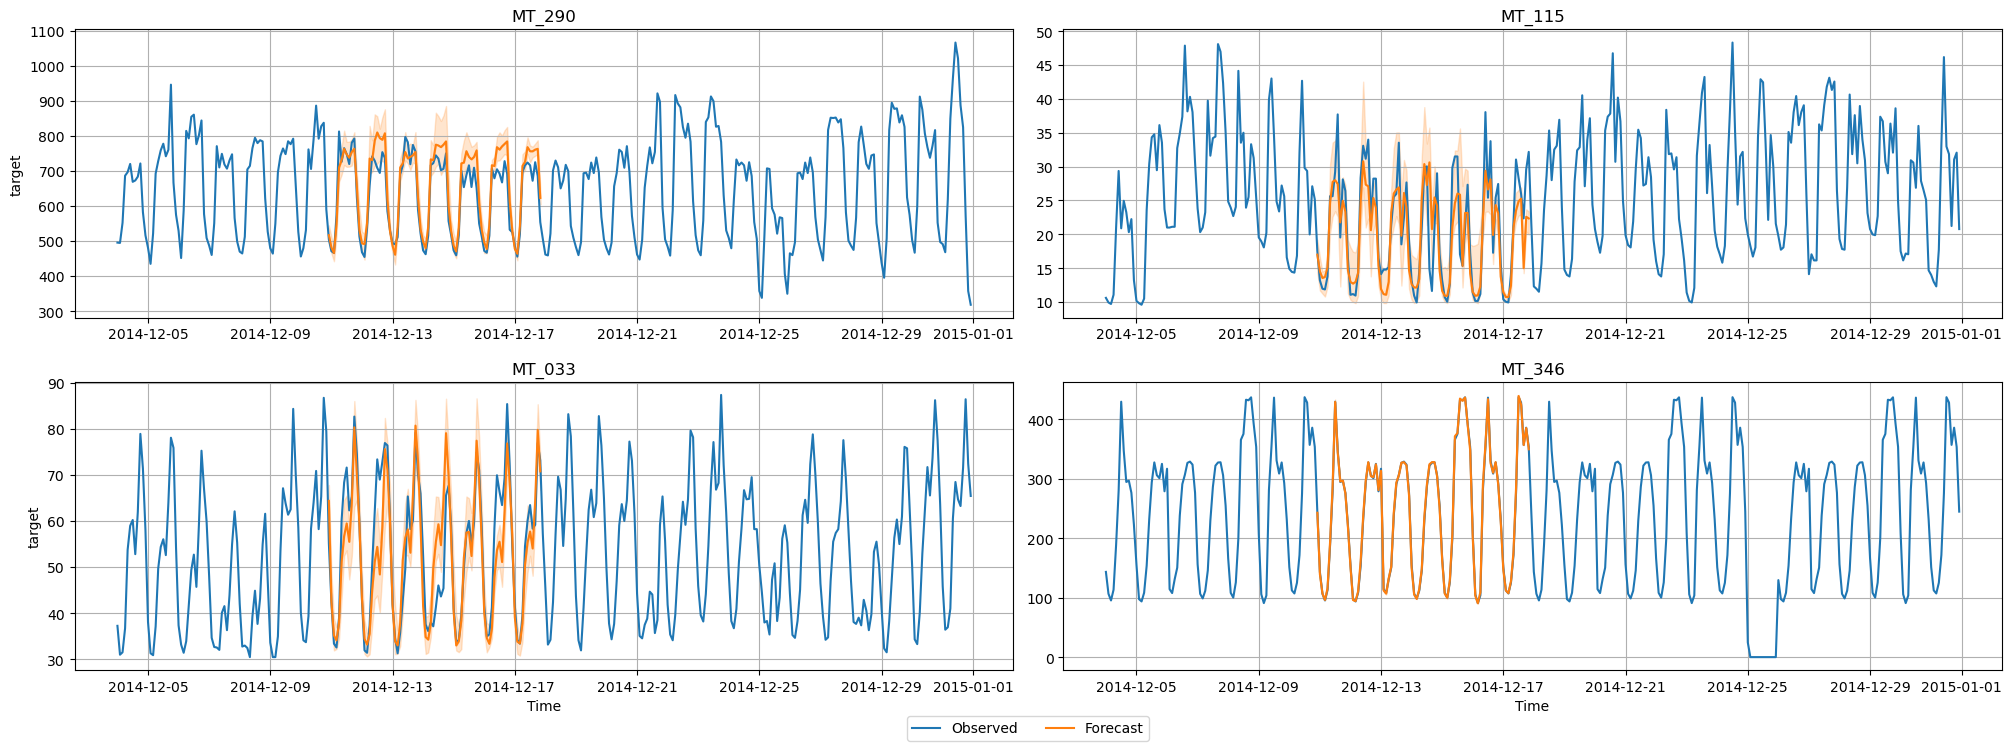

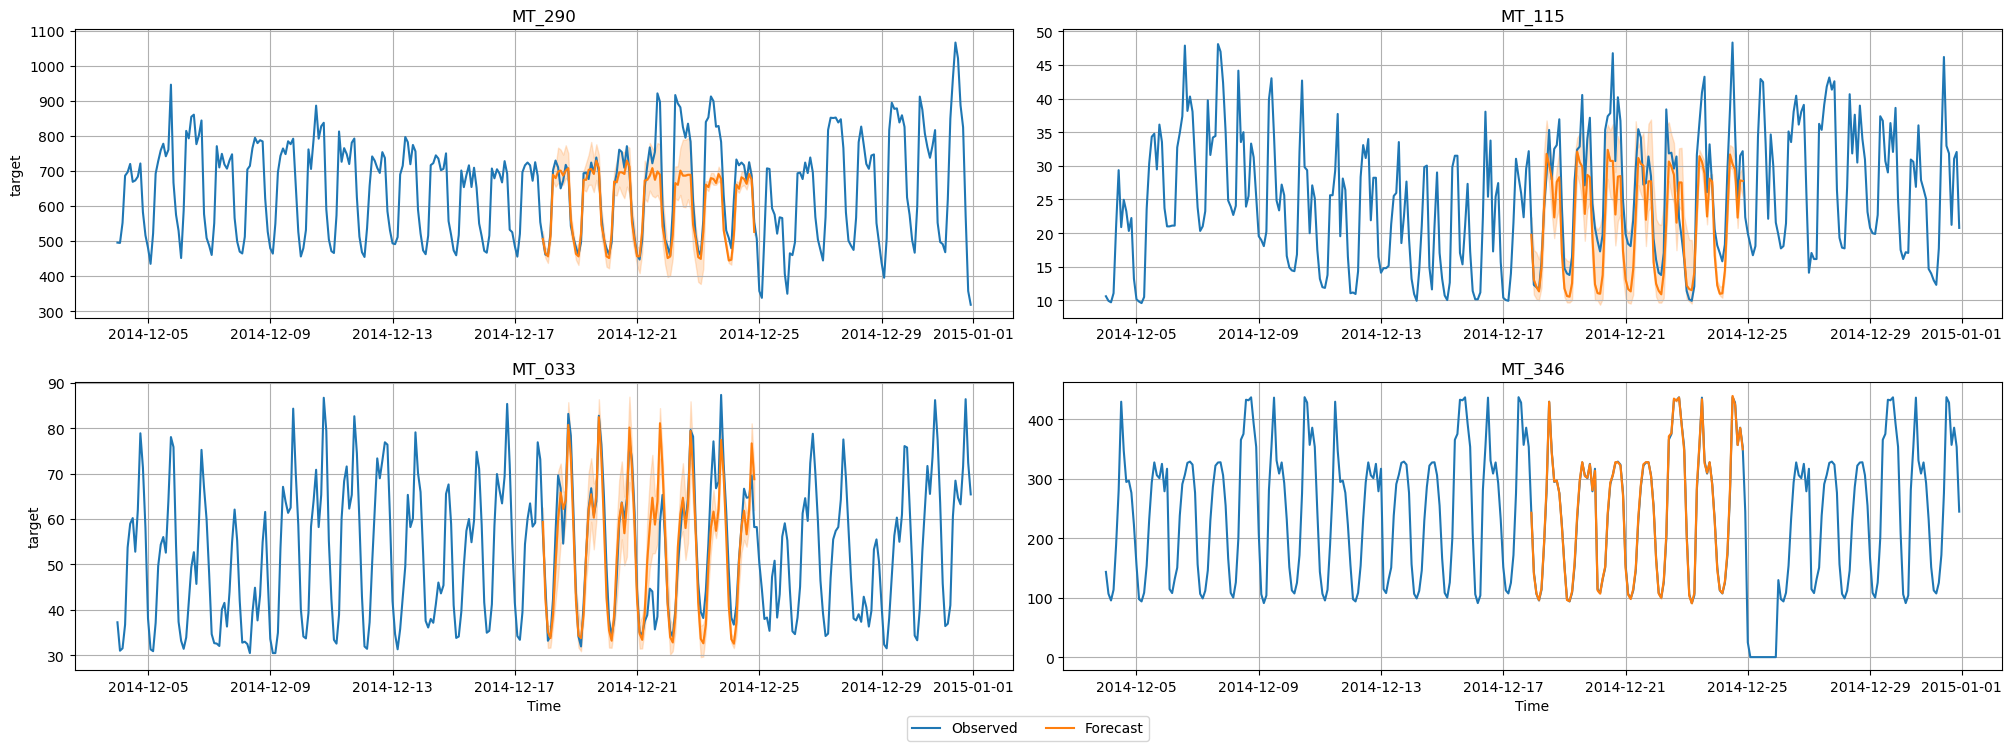

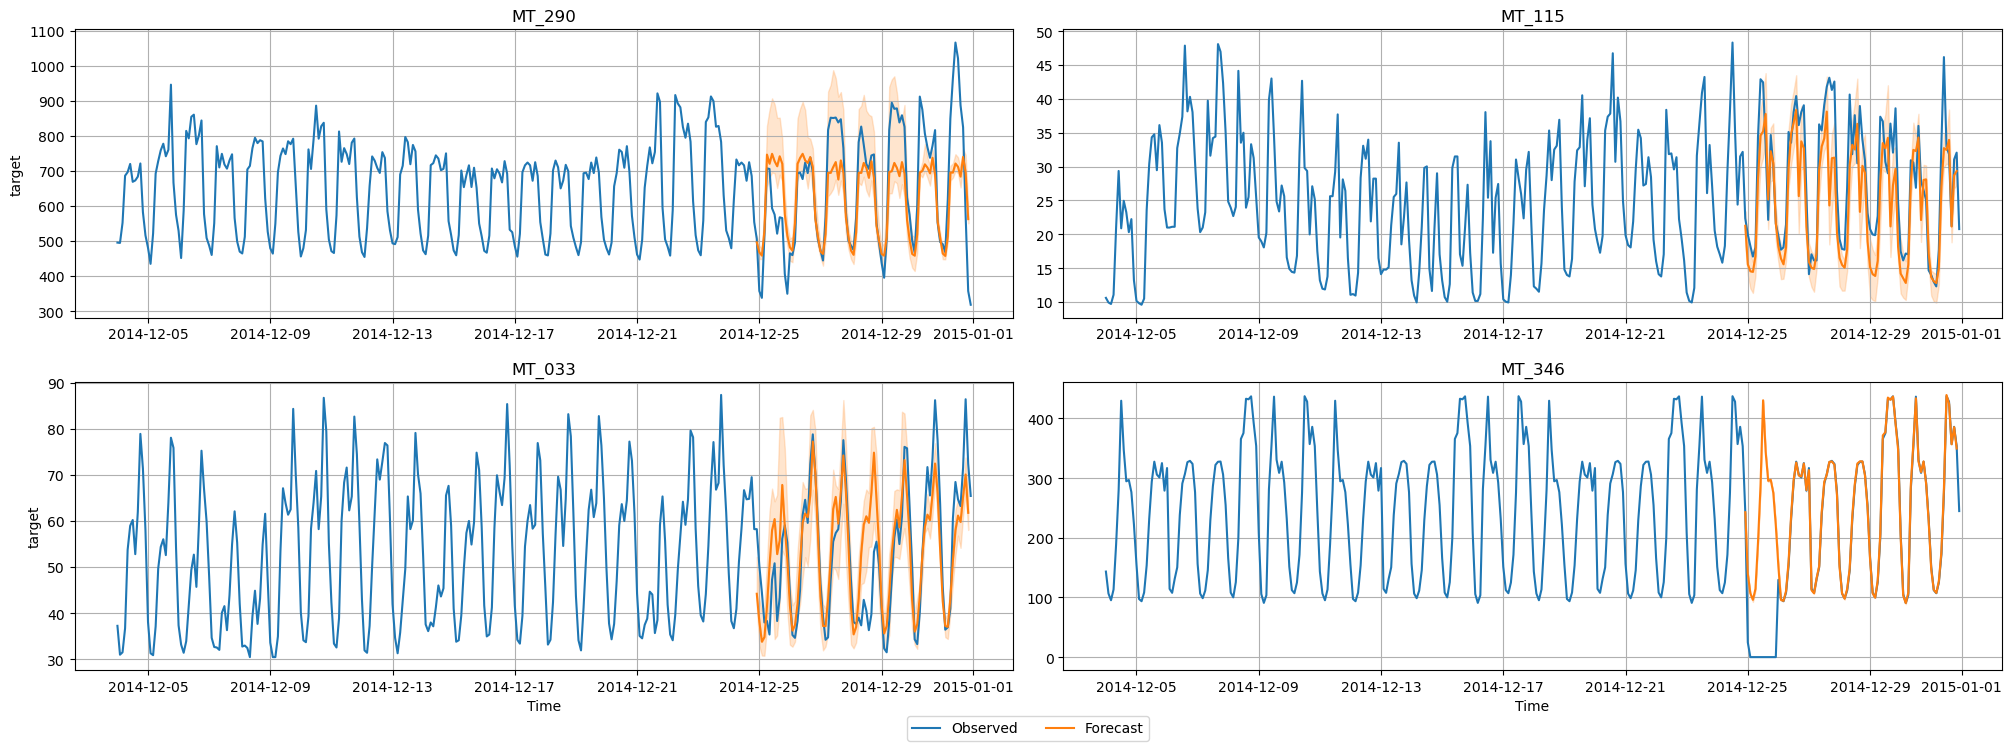

In [277]:
data = get_ts_df(test_data[inference_items]).slice_by_timestep(end_index=-1)
splitter = ExpandingWindowSplitter(prediction_length=prediction_length, num_val_windows=n_windows)
scores = []

for window_idx, (train_split, val_split) in enumerate(splitter.split(data.slice_by_timestep(end_index=-1))):
    # predict
    split_prediction_df = predict_ag(
        val_split.slice_by_timestep(start_index=-context_length-prediction_length, end_index=-prediction_length), 
        prediction_length=prediction_length,
    )
    
    # visualize
    chronos_predictor_ag.plot(
        data=data.slice_by_timestep(start_index=-n_windows*prediction_length),
        predictions=split_prediction_df,
        item_ids=inference_items,
    )
    
    # # evaluate
    score = get_scores(
        metrics, 
        val_split, 
        split_prediction_df
    )
    
    print(f"Window {window_idx} score:\n{score}")
    scores.append(score)

pd.DataFrame(scores)

Create an evaluation function using code from the previous code cell:

In [ ]:
def run_backtest_with_windows(
    model: str,
    test_data: pd.DataFrame,
    item_ids: [str],
    metrics,
    prediction_length: int,
    context_length: int,
    batch_size: int,
    n_windows: int,
    display_items = False,
    
) -> pd.DataFrame:

    print(f"""
    Running inference and scoring with rolling windows for model: {model} 
    Number of time series: {len(item_ids)} sent in batches of {batch_size}
    Context length: {context_length} Prediction lenght: {prediction_length} Offset: 1 Number of windows: {n_windows}
    """)

    scores = []

    for i in (pbar := trange(-(len(item_ids)//-batch_size))):
        inference_items = item_ids[i*batch_size:(i+1)*batch_size]
        if display_items: pbar.write(f"Inferencing the items: {inference_items}")
            
        data = get_ts_df(test_data[inference_items]).slice_by_timestep(end_index=-1)
        splitter = ExpandingWindowSplitter(prediction_length=prediction_length, num_val_windows=n_windows)
        
        for window_idx, (train_split, val_split) in enumerate(splitter.split(data.slice_by_timestep(end_index=-1))):
            scores.append(predict_and_score(
                        val_split,
                        val_split.slice_by_timestep(
                            start_index=-context_length-prediction_length, 
                            end_index=-prediction_length
                        ),
                        metrics,
                        model=model,
                        offset=1,
                    )
                )
    
    return pd.DataFrame(scores)

In [283]:
# prepare agruments for the function call
kwargs = {
    'test_data': test_data,
    'item_ids': test_data.columns.to_list(),
    'metrics': metrics,
    'prediction_length': prediction_length,
    'context_length': context_length,
    'batch_size': batch_size,
    'n_windows': n_windows,
}

<div class="alert alert-info">The backtest with rolling windows run with three deployed Chronos models and the full dataset takes about 15 minutes.</div>

In [284]:
# run backtest with N rolling windows for all deployed models
rolling_windows_scores = [
    {'model':m, 'score':run_backtest_with_windows(model=m, **kwargs)} for m in chronos_predictors.keys()
]


    Running inference and scoring with rolling windows for model: chronos-t5-small 
    Number of time series: 370 sent in batches of 50
    Context length: 168 Prediction lenght: 84 Offset: 1 Number of windows: 4
    


  0%|          | 0/8 [00:00<?, ?it/s]


    Running inference and scoring with rolling windows for model: chronos-t5-base 
    Number of time series: 370 sent in batches of 50
    Context length: 168 Prediction lenght: 84 Offset: 1 Number of windows: 4
    


  0%|          | 0/8 [00:00<?, ?it/s]


    Running inference and scoring with rolling windows for model: chronos-t5-large 
    Number of time series: 370 sent in batches of 50
    Context length: 168 Prediction lenght: 84 Offset: 1 Number of windows: 4
    


  0%|          | 0/8 [00:00<?, ?it/s]

In [285]:
# display scores for each model
# using mean() here to aggregate metrics over all time series
[print(f"Model: {s['model']}\n{s['score'].mean()}") for s in rolling_windows_scores]

Model: chronos-t5-small
WQL      -0.083191
MAPE     -0.965906
WAPE     -0.111863
RMSE   -297.744859
MASE     -1.917336
dtype: float64
Model: chronos-t5-base
WQL      -0.075254
MAPE     -0.594981
WAPE     -0.102735
RMSE   -268.090108
MASE     -1.833500
dtype: float64
Model: chronos-t5-large
WQL      -0.073115
MAPE     -0.769731
WAPE     -0.101091
RMSE   -275.717974
MASE     -1.791825
dtype: float64


[None, None, None]

#### Save the model performance to a file

In [286]:
# construct a DataFrame with all metrics for all models for rollwing windows
model_rolling_windows_metrics_df = pd.concat([
    get_metrics_df(
        s['score'].mean().to_dict(),
        f"{experiment_prefix}-{s['model']}-{freq}-{test_data.shape[1]}-{test_data.shape[0]}-bt{n_windows}",
    ) for s in rolling_windows_scores
])

model_rolling_windows_metrics_df

,timestamp,metric_name,value,experiment
0,20240917-205300,WQL,0.083191,chronos-chronos-t5-small-2H-370-17533-bt4
1,20240917-205300,MAPE,0.965906,chronos-chronos-t5-small-2H-370-17533-bt4
2,20240917-205300,WAPE,0.111863,chronos-chronos-t5-small-2H-370-17533-bt4
3,20240917-205300,RMSE,297.744859,chronos-chronos-t5-small-2H-370-17533-bt4
4,20240917-205300,MASE,1.917336,chronos-chronos-t5-small-2H-370-17533-bt4
0,20240917-205300,WQL,0.075254,chronos-chronos-t5-base-2H-370-17533-bt4
1,20240917-205300,MAPE,0.594981,chronos-chronos-t5-base-2H-370-17533-bt4
2,20240917-205300,WAPE,0.102735,chronos-chronos-t5-base-2H-370-17533-bt4
3,20240917-205300,RMSE,268.090108,chronos-chronos-t5-base-2H-370-17533-bt4
4,20240917-205300,MASE,1.833500,chronos-chronos-t5-base-2H-370-17533-bt4


In [287]:
# save the metrics df to the file
experiment_name = f"{experiment_prefix}-{freq}-{test_data.shape[1]}-{test_data.shape[0]}-bt{n_windows}"
model_rolling_windows_metrics_df.to_csv(
    f"./model-performance/{experiment_name}-{model_rolling_windows_metrics_df['timestamp'].iloc[0]}.csv",
    index=False
)

### Alternative approaches to backtest

Giving the input time series and predictions, you can calculate the model performance using any approach. For example, you can use [GluonTS](https://ts.gluon.ai/stable/index.html) library for Chronos forecast evaluation as described in [evaluating Chronos models](https://github.com/amazon-science/chronos-forecasting/tree/main/scripts#evaluating-chronos-models) section of Chronos documentation.

---

## Pre-train and fine-tune Chronos models

If you want to train a Chronos model on your historical data and for your specific business domain, you can pre-train and fine-tune a foundation model. Start with the [documentation](https://github.com/amazon-science/chronos-forecasting/tree/main/scripts#pretraining-and-fine-tuning-chronos-models) on the Chronos GitHub.

## Using LLMs for zero-shot time series forecast

If you're interested in this approach to use LLMs for time series prediction, you might look at alternative models:
- [**ForecastPFN**](https://arxiv.org/abs/2311.01933): ForecastPFN tackles zero-shot forecasting by training a transformer-based model on synthetic data. While it shows promise, it's limited to generating point forecasts rather than probabilistic ones like Chronos. See ForecastPFN GitHub [repo](https://github.com/abacusai/ForecastPFN) for the source code and examples.
- [**LLMTime**](https://arxiv.org/pdf/2310.07820): LLMTime, developed by Gruver et al., shows zero-shot performance comparable to or exceeding purpose-built time series models. It uses models like GPT-3 and LLaMA-2 to extrapolate time series data encoded as strings of numerical digits. See LLMTime GitHub [repo](https://github.com/ngruver/llmtime) for the source code.
- [**LSTPrompt**](https://arxiv.org/abs/2402.16132): LSTPrompt exhibits enhanced long-term prediction stability compared to LLMTime. It uses a novel prompt paradigm with modules like TimeDecomp and TimeBreath to improve zero-shot forecasting accuracy. See also LSTPrompt GitHub [repo](https://github.com/AdityaLab/lstprompt)
- [**TimeGPT**](https://arxiv.org/abs/2310.03589): TimeGPT by [Nixtla](https://docs.nixtla.io/) was one of the first foundation models developed for forecasting.

---

## Clean up

In [288]:
for p in chronos_predictors.values():
    print(f"Deleting endpont {p.endpoint_name}")
    p.delete_endpoint()

Deleting endpont autogluon-forecasting-chronos-t5-small-2024-09-17-09-47-57-453
Deleting endpont autogluon-forecasting-chronos-t5-base-2024-09-17-09-47-59-221
Deleting endpont autogluon-forecasting-chronos-t5-large-2024-09-17-09-48-00-949


## Shutdown kernel

In [ ]:
%%html

<p><b>Shutting down your kernel for this notebook to release resources.</b></p>
<button class="sm-command-button" data-commandlinker-command="kernelmenu:shutdown" style="display:none;">Shutdown Kernel</button>
        
<script>
try {
    els = document.getElementsByClassName("sm-command-button");
    els[0].click();
}
catch(err) {
    // NoOp
}    
</script>